# ACN 903 / INF 674, Session #4: Distances and Clustering

## Céline Comte & Fabien Mathieu

### 2017-2018

During the course, you will learn how to study real-life datasets. The goal of this practical is to begin with simple (e.g. non-oriented) graphs. Two datasets are proposed: DBLP and IMDB. In further practicals, you will also play with oriented graphs using Wikipedia datasets.

**Remark:** the IMDB dataset is much larger than the DBLP dataset. You should play with only *after* you mastered the DBLP dataset.

In [1]:
%pylab inline
import networkx as nx
import zipfile
import codecs

Populating the interactive namespace from numpy and matplotlib


# 1. Basic Tools

We provide you with a few functions to deal with the dataset format. You will have to use them in the practical. There are strictly speaking no question for this part, yet it is **strongly** advised that you take your time to understand how the different functions proposed here work.

## File format

The datasets are provided in the form of *zip* archives. Inside each *zip* archive are the following files:
- **_dataset_.ids** contains the actual names of the nodes (one per line, $ n $ lines in total). By convention, each node is associated to its line number (from $ 0 $ to $ n-1 $). Actual names may contain special characters (e.g. *ç*, *é*), so it is encoded with *utf-8*.
- **_dataset_.adja** contains the adjacency list of the graph: line $ i $ (from $ 0 $ to $ n-1 $) contains, in plain ASCII, the numbers of the nodes that are neighbors of $ i $.
- For oriented graphs, **_dataset_-t.adja** contains the adjacency list of the transposed graph: line $ i $ (from $ 0 $ to $ n-1 $) contains, in plain ASCII, the numbers of the nodes that are linked by $ i $.


Datasets will be given on a USB key. This practical assumes they are stored in **../Datasets/** relatively to your working directory.

In [2]:
directory = "../Datasets/"

Most of the core functions below have the following behavior: first they try to load the results from a npy file if one exists, otherwise they parse through the dataset to extract the information and save it in a npy file for the next use. This approach avoids re-doing the same work over and over.

## Size

The following function gives the number of nodes $n$ and the total number of *oriented edges* $m$ of the graph. In the case where the graph is undirected, all edges will be counted twice ($(i,j)$ and $(j,i)$ are the same edge on an undirected graph) so the actual number of edges is $\frac m 2$.

In [3]:
def get_size(prefix = "dblp"):
    try:
        return np.load(directory+prefix+"-size.npy")
    except IOError:
        n = 0
        m = 0
        with zipfile.ZipFile(directory+prefix+".zip") as myzip:
            with myzip.open(prefix+".adja") as f:
                for line in f:
                    n += 1
                    m += len([int(s) for s in line.split()])
        np.save(directory+prefix+"-size", [n, m])
        return n, m

Let us run the function to create the npy file.

In [4]:
prefix = "dblp"
n, m = get_size(prefix)
print("Number of nodes in %s: %s" % (prefix, n))
print("Number of edges in %s: %s" % (prefix, m//2))

Number of nodes in dblp: 1314050
Number of edges in dblp: 5362414


## Adjacency List

A natural way to store the adjacency list would be to use an array (or list) of arrays (or lists), such that A[i][j] would refer to the $j$th neighbor of node $i$. In practice, this structure can have some memory usage overhead, so we will store the adjacency list in a flat array with the function below.

In [7]:
def get_adjacency(prefix = "dblp"):
    try:
        return np.load(directory+prefix+"-adja.npy")
    except IOError:
        n, m = get_size(prefix)
        A = zeros(n+m+1, dtype = int)
        A[0] = n+1 # Don't forget the +1!!!
        with zipfile.ZipFile(directory+prefix+".zip") as myzip:
            with myzip.open(prefix+".adja") as f:
                i = 0
                for line in f:
                    neighbors = array(line.split(), dtype = int)
                    A[i+1] = A[i]+len(neighbors)
                    A[A[i]:A[i+1]] = neighbors
                    i += 1
        np.save(directory+prefix+"-adja", A)
        return A

We can load $A$ in memory.

In [8]:
A = get_adjacency("dblp")

The result, *A*, is a numpy array of integer of size $n+m+1$, organized as follows:
- The $n+1$ first values are indexes
- The $m$ last values are destinations
- The neighbors of a node $i$ are stored in A[A[i]:A[i+1]]

The following function just return the neighbors.

In [9]:
def neighbors(A, index):
    return A[A[index]:A[index+1]]

In practice, just use A[A[i]:A[i+1]] if you can, it avoids calling a function.

## Index / Name conversion

All the functions above assume a node is represented by an integer $0\leq i<n$, but researchers, Wikipedia pages, and even actors have names! Let us write some functions to translate integers to names and *vice versa*.

In [10]:
def get_ids(prefix = "dblp"):
    try:
        return np.load(directory+prefix+"-ids.npy")
    except IOError:
        n, m = get_size(prefix)
        delimiter = zeros(n+1, dtype = int)
        text = ""
        with zipfile.ZipFile(directory+prefix+".zip") as myzip:
            with myzip.open(prefix+".ids") as f:
                i = 0
                for line in codecs.iterdecode(f, 'utf8'):
                    delimiter[i+1] = delimiter[i]+len(line)-1
                    text += line[0:-1]
                    i += 1
        np.save(directory+prefix+"-ids", [delimiter, text])
        return delimiter, text

The function above returns a *delimiter* array of size $n+1$ and a *text* string that concatenates all researcher names. It uses the same principle used for the adjacency list: the name of a researcher associated to number $i$ is text[delimiter[i]:delimiter[i+1]]. This allows us to do the conversion from name to index, and vice versa.

In [11]:
def index2name(index, prefix = "dblp", delimiter = None, text = None):
    if delimiter is None:
        delimiter, text = get_ids(prefix)
    return text[delimiter[index]:delimiter[index+1]]

In [12]:
def name2index(name, prefix = "dblp", delimiter = None, text = None):
    try:
        if delimiter is None:
            delimiter, text = get_ids(prefix)
        offset = text.index(name)
        return where(delimiter == offset)[0][0]
    except:
        print("Name not found.")

Let us try with some names. Note that the first execution will build the index.

In [13]:
name2index("Paul_Erdös")

711561

In [14]:
name2index("Fabien_Mathieu")

149114

In [15]:
index2name(711561)

'Paul_Erdös'

In [16]:
index2name(149114)

'Fabien_Mathieu'

Remark: the **name2index** function is very rough: it just try to match *name* as a substring of *text* and find the corresponding index in the delimiter array. It is quite slow and may fail is the name of a researcher is a substring of the name of another researcher, but it will be enough for this practical.

## List comprehension

You already seen *list comprehension* before: it is for example used in some of the function above to convert a text line into a list of neighbors when you parse the adjacency list: [int(s) for s in line.split()]

They are a powerful tool to construct a list by describing how it is built, and you will have to use them in this practical, so you should study the following examples.

A first simple example: the list of the squares of the integers from 0 to 5:

In [17]:
[i**2 for i in range(6)]

[0, 1, 4, 9, 16, 25]

One of the interest of list comprehension is that they can be nested. For example, the list of the squares of the 6 first positive odd integers.

In [18]:
[i**2 for i in [2*k+1 for k in range(6)]]

[1, 9, 25, 49, 81, 121]

A last example of list comprehension, which will be very helpful for the clustering coefficient. Can you figure out what it does?

In [19]:
[k for nj in [range(j) for j in range(6)] for k in nj]

[0, 0, 1, 0, 1, 2, 0, 1, 2, 3, 0, 1, 2, 3, 4]

# 2. Distances and neighborhood

## Question 1

Let us check that you can use the tools above: write a function **coauthors** that gives you the co-authors of someone. It should take a string as input and return a list of strings.

**Answer:**

## Question 2

Write a function that takes a node index and gives its distance from Erdös. Use it to compute the Erdös number of Fabien Mathieu.

**Answer:**

## Question 3

Compute the number of researchers at distance $i$ from a node given by its index. Compare the number of researchers at distance 3 from the following researchers:
- "Paul_Erdös"
- "Fabrice_Lumineau"
- "Fabien_Mathieu"
- "Jean-Louis_Rougier"

**Answer:**

## Question 4 (Bonus)

Write a function that takes a node index and gives a shortest path from Erdös. Test it.

# 3. Clustering Coefficient 

Informally, the clustering definition tells how likely it is that the friend of your friend is your friend. In other words, it tries to quantify the so-call *small-world* effect.

When one wants to give a proper definition of what is a clustering coefficient, multiple options exist. For this practical, we will rely on the metrics introduced by Newman in
[The structure and function of complex networks][newman]. Note that these are the definitions proposed in Wikipedia (avoid the French version by the way, the translation is lossy).

Note that we will slightly alter some of the definitions proposed by [Newman][newman] to simplify the practical, but the metrics are exactly the same.

[newman]: http://math.uchicago.edu/~shmuel/Network-course-readings/Newman,%20SIAM.pdf "The structure and function of complex networks by M.E.J. Newman"

## Definitions



For a simple graph $G = (V,E)$ (*simple* means not oriented, no loops). We introduce the following notation for a node $i \in V$:
- $N(i):= \{j\in V \big| (i,j)\in E\}$ is the *neighborhood* of $i$. Note that $d_i:=|N(i)|$ is the degree of $i$.
- $B(i):= \{(j,k)\in V^2 \big| (i,j)\in E, (i,k)\in E, j\neq k\}$ are the *edge pairs* of $i$. Note that the tuple $(j,k)$ is oriented ($(j,k)\neq(k,j)$). $b_i$ denotes $|B(i)|$. It is straightforward to check that $b_i = d_i(d_i-1)$
- $T(i):= \{(j,k)\in V^2 \big| (i,j)\in E, (i,k)\in E, (j,k)\in E\}$ are the *oriented triangles* of $i$. Note that the tuple $(j,k)$ is oriented ($(j,k)\neq(k,j)$). $t_i$ denotes $|T(i)|$.

Remark that $T(i)\subseteq B(i)$: all oriented triangles are also edge pairs, the only difference is the existence of an edge between the pair nodes.

The clustering coefficient just measures the ratio between $T$ and $B$. It comes in two flavors, local and global:
- The *local* clustering coefficient of a node $i$ is the ratio $c_i:=\frac{t_i}{b_i}$. By convention, for $d_i=0$ (isolated node) or $d_i=1$ (leaf), we assume $c_i = 0$.
- The *average local* clustering coefficient $C_l$ is just the average $C_l:=\frac{1}{|V|}\sum_{i\in V}c_i$.
- The *global* clustering coefficient $C_g$ is the ratio between the total number of oriented triangles and the total number of edge pairs: $C_g:= \frac{\sum_{i\in V} t_i}{\sum_{i\in V} b_i}$.

Last definition: the *reference clustering* of a simple graph $G = (V, E)$ is defined as $C_r:=\frac{2|E|}{|V|(|V|-1)}$. It corresponds to the typical clustering coefficient one would observe on a random graph (e.g. Erdös-Rényi) having in average the same number of nodes and edges than $G$.

[newman]: http://math.uchicago.edu/~shmuel/Network-course-readings/Newman,%20SIAM.pdf "The structure and function of complex networks by M.E.J. Newman"

## Example

To illustrate the definitions above, consider the following graph :
- $V = \{A, B, C, D\}$
- $E = \{(AB), (AC), (AD), (BC)\}$ 

It is displayed in the cell below in GraphViz, but you may need a working installation of GraphViz for it to display correctly. If you want to see it (this is optional, unless you want to do bonus question 3.3), you'll need to:
- install GraphViz on your computer (http://www.graphviz.org/Download.php)
- make sure the binaries are in your path (for Windows users)
- install the Python interface: *pip install graphviz*

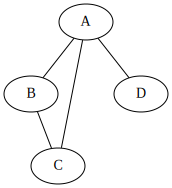

In [29]:
from graphviz import Graph
d = Graph(strict = True)
d.edge("A","B")
d.edge("A","C")
d.edge("B","C")
d.edge("A","D")
d

We have the following:
- Local clustering coefficients:
    - $A$ has 6 edge pairs and 2 oriented triangles: $c_A = \frac 1 3$
    - $B$ has 2 edge pairs and 2 oriented triangles: $c_B = 1$
    - $C$ has 2 edge pairs and 2 oriented triangles: $c_C = 1$
    - $D$ has 0 edge pairs and 0 oriented triangles: $c_D = 0$ by convention.
- Average local clustering: $C_l = \frac{1/3+1+1+0}{4}=\frac{7}{12}$.
- Global clustering coefficient: $C_g = \frac{2+2+2+0}{6+2+2+0} = \frac{3}{5}$
    - Notice that $C_g\neq C_l$.
    - One verifies that $C_g = \frac{1}{10}(6c_A+2c_B+2c_C+0c_D)$.
- Reference clustering: $C_r = \frac{4}{3\times 2} = \frac 2 3$

**Remark:** you may have noticed that the reference clustering is greater than the others, yet it is impossible to produce a graph with 4 nodes and 4 edges with a higher clustering. The short answer is that is is a border effect due to the small size of the graph. A deeper, slightly longer answer can be provided on demand.


## Question 1

Express the global clustering as a function of the local clusterings. Discuss qualitatively how the average local clustering and the global clustering may differ.

**Answer:**

## Question 2

Give a function that tells the local clustering coefficient $c_i$ of a node with id $i$ in DBLP. Try to make it as fast as possible.

**Hints:**
- The adjacency list you computed above will be quite useful.
- Your main focus should be the computation of the number of oriented triangles of $i$.
    - You can remark that $(j,k)$ is an oriented triangle of $i$ iff $j\in N(i)$, $k\in N(j)$ and $k\in N(i)$.
    - In particular, if you compute the set $N^2(i):=\cup_{j\in N(i)}N(j)$ with multiplicity (a given $k$ can be in the set multiple times if it is the neighbors of multiple $j$'s), you *just* have to count the number of elements of $N^2(i)$ that belongs to $N(i)$.
    - So you need to compute $N^2(i) = \{k \in N(j)\text{ s.t. }j\in N(i)\}$ (with multiplicity). Maybe it is time for you to start using the full power of list comprehension (see examples from [Basic Tools](#List-comprehension)).
    - Look at the **numpy** function **in1d**, it may be handy.
- Remind that a function call can slow down the execution. If it is a very small function, it may be faster to just rewrite it.
- To check your code, here are a few local clusterings:
    - "Marc-Olivier_Buob": 0.667
    - "Thomas_H._Clausen": 0.263
    - "Paul_Erdös": 0.039    
    - "Fabien_Mathieu": 0.159
    - "Jean-Louis_Rougier": 0.132

**Answer:**

## Question 3 (Bonus)

Write a function that displays the neighborhood graph of a node $i$ using GraphViz. The neighborhood graph of $i$, denoted $G(i) = (V(i), E(i))$, is such that:
- $V(i) = \{i\}\cup N(i)$
- $E(i) = \{(j,k)\in E, j \in V(i), k \in V(i)\}$

Test it on a few researchers (avoid researchers with too many co-authors if you want to see something) to see how it looks.

**Answer:**

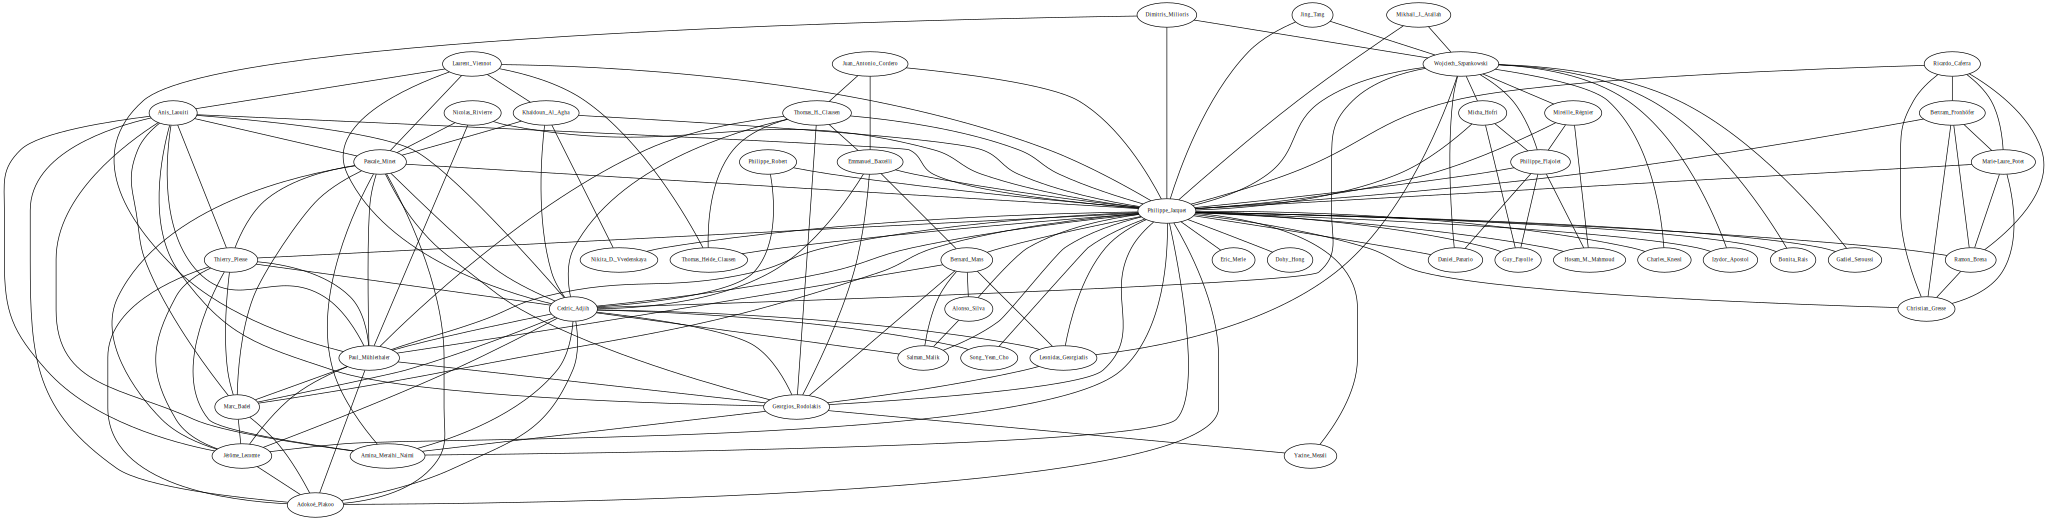

In [35]:
g = draw_neighbors("Philippe_Jacquet")
g

## Question 4

Using list comprehensions, compute the list of $t_i$, then $C_l$, $C_g$, and $C_r$ for the DBLP graph.
- You can compute the $t_i$ in just one list comprehension (possibly nested).
- The computation of $t_i$ should take about 1-10 minutes if you have a clean code
    - Check your speed on small scales before launching the full computation.
    - Optimize your code!
    - you should save the result. Note that a list comprehension returns a Python list, which you may want to turn into a numpy array with *np.array()*.

**Answer:**

## Question 5

Discuss the values of $C_r$, $C_l$ and $C_g$. Can you give some explanation?

(this a question where you can show your discussion skills, try to say interesting things)

**Answer:**

## Question 6 (bonus)

The DBLP dataset comes from

http://konect.uni-koblenz.de/downloads/tsv/dblp_coauthor.tar.bz2

The format was not exactly the one used here, so it was converted with the following code.

Sadly, the intern that wrote the code didn't comment it. Can you reverse engineer the code and explain how it works?

# 4. Going IMDB (bonus)

Try to redo the practical using the IMDB dataset. As it is a bigger dataset, you will have to be cautious.
- You can use *Bacon, Kevin*, and *Rochefort, Jean*, *Hallyday, Johnny* as examples.
- 2 Go of usable RAM recommended.
- Do not compute Question 3.4 for IMDB during the practical!



**Answer:**